In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import hsv_to_rgb
from matplotlib.animation import FuncAnimation, PillowWriter
import os
dur = 40
n_show = 95
emb_dim = 3
N_angles = 8
idx1, idx2, idx3 = 0, 1, 2
file_name = './data_NER/Fig2/Chewie_161014_embed_20000itr_M1.npz'
data_single_session = np.load(file_name)
emb_A = data_single_session['cebra_veldir_train'][:dur*n_show, :]
XY = data_single_session['continuous_index_train'][:dur*n_show, 0:2]
trial_angle = data_single_session['continuous_index_train'][:dur*n_show, 2]//45

<IPython.core.display.Javascript object>


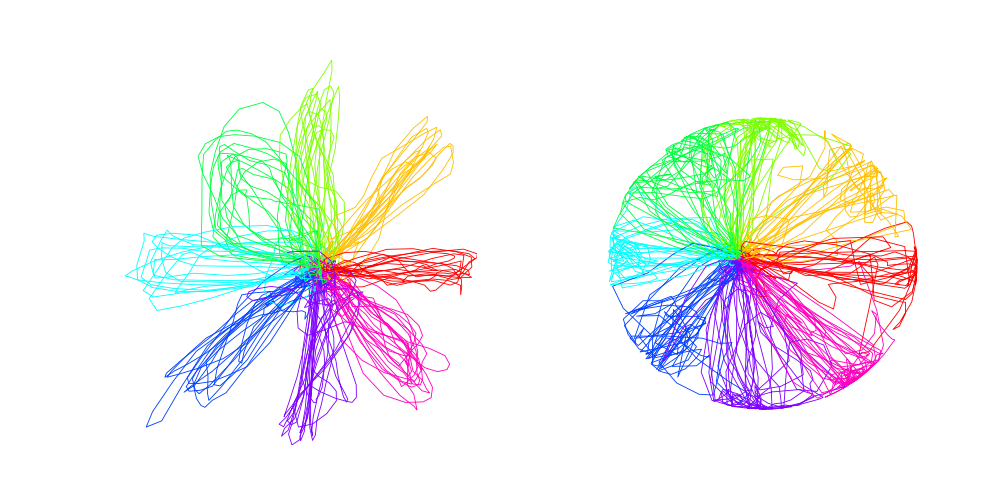

In [2]:
# Define the number of time bins per trial
time_bins_per_trial = 40
n_trials = emb_A.shape[0] // time_bins_per_trial  # 592 trials

%matplotlib notebook
# Create a figure with two subplots: one for 2D (XY) and one for 3D (emb_A)
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(8, 4))
ax_right = fig.add_subplot(122, projection='3d')

# Set limits for the 2D (XY) plot
ax_left.set_xlim(np.min(XY[:, 0]), np.max(XY[:, 0]))
ax_left.set_ylim(np.min(XY[:, 1]), np.max(XY[:, 1]))
# ax_left.set_title('2D Movement Trajectories')
ax_left.set_xticks([])
ax_left.set_yticks([])
ax_left.spines['top'].set_visible(False)
ax_left.spines['right'].set_visible(False)
ax_left.spines['bottom'].set_visible(False)
ax_left.spines['left'].set_visible(False)

ax_right.set_xlim(np.min(emb_A[:, 0]), np.max(emb_A[:, 0]))
ax_right.set_ylim(np.min(emb_A[:, 1]), np.max(emb_A[:, 1]))
ax_right.set_zlim(np.min(emb_A[:, 2]), np.max(emb_A[:, 2]))
# ax_right.set_title('3D Latent Dynamics')

# Remove ticks, grid, and spines (unnecessary visual elements)
ax_right.set_facecolor('white')  # Set background color to white
ax_right.grid(False)  # Remove grid
ax_right.xaxis.pane.fill = False  # Remove background panes
ax_right.yaxis.pane.fill = False
ax_right.zaxis.pane.fill = False
ax_right.set_xticks([])  # Remove X ticks
ax_right.set_yticks([])  # Remove Y ticks
ax_right.set_zticks([])  # Remove Z ticks
# ax_right.xaxis.line.set_color((1.0, 1.0, 1.0, 1.0))  # Remove axis lines
# ax_right.yaxis.line.set_color((1.0, 1.0, 1.0, 1.0))
# ax_right.zaxis.line.set_color((1.0, 1.0, 1.0, 1.0))

# Remove the 3D axis lines by making them transparent
ax_right.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Make X axis line transparent
ax_right.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Make Y axis line transparent
ax_right.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Make Z axis line transparent

# Hide the outer box of the 3D plot (which includes the top and left "spines")
ax_right.xaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))  # Remove X pane edges
ax_right.yaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))  # Remove Y pane edges
ax_right.zaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))  # Remove Z pane edges

box = ax_right.get_position()
ax_right.set_position([box.x0-0.04, box.y0-0.18, box.width * 1.4, box.height * 1.4]) ##W8 H4

ax_right.view_init(elev=119, azim=114)

# Create a list to store all the trial lines for both subplots
lines_2d = []  # For the left 2D plot
lines_3d = []  # For the right 3D plot

# Create empty lines for each trial
for i in range(n_trials):
    line_2d, = ax_left.plot([], [], lw = 0.5)  # Create empty line for 2D plot>>> 'o-', markersize = 1
    lines_2d.append(line_2d)
    
    line_3d, = ax_right.plot([], [], [], lw = 0.5)  # Create empty line for 3D plot
    lines_3d.append(line_3d)

# Parameters for delay
initial_delay = 20  # Starting delay
final_delay = 1  # Ending delay

# Function to compute gradually reducing delay between trials
def get_delay(trial_idx):
    return max(initial_delay - (initial_delay - final_delay) * (trial_idx / n_trials), final_delay)

# Initialization function to clear the plot
def init():
    for line in lines_2d:
        line.set_data([], [])
    for line in lines_3d:
        line.set_data([], [])
        line.set_3d_properties([])
    return lines_2d + lines_3d

# Update function to animate each trial on both subplots with a reducing delay
def update(frame):
    cumulative_delay = 0
    for i in range(n_trials):
        delay_i = get_delay(i)  # Get the delay for trial i
        start_frame = int(cumulative_delay)  # Calculate the start frame for each trial
        cumulative_delay += delay_i  # Update cumulative delay
        
        if frame >= start_frame:  # Start the trial after its delay
            trial_frame = frame - start_frame  # Frame relative to the trial's start
            if trial_frame < time_bins_per_trial:  # Only update within trial duration
                
                # Update the 2D XY plot
                trial_data_2d = XY[i * time_bins_per_trial:(i + 1) * time_bins_per_trial]
                angle = trial_angle[i * time_bins_per_trial]
                hue = angle / 8.0
                color = hsv_to_rgb([hue, 1, 1])  # Map angle to HSV color
                lines_2d[i].set_data(trial_data_2d[:trial_frame, 0], trial_data_2d[:trial_frame, 1])
                lines_2d[i].set_color(color)
                
                # Update the 3D XYZ plot
                trial_data_3d = emb_A[i * time_bins_per_trial:(i + 1) * time_bins_per_trial]
                lines_3d[i].set_data(trial_data_3d[:trial_frame, 0], trial_data_3d[:trial_frame, 1])
                lines_3d[i].set_3d_properties(trial_data_3d[:trial_frame, 2])
                lines_3d[i].set_color(color)
    
    return lines_2d + lines_3d

# Calculate total frames by summing the gradually reducing delays
total_frames = int(sum(get_delay(i) for i in range(n_trials))) + time_bins_per_trial

# Create animation
ani = FuncAnimation(fig, update, frames=range(total_frames), init_func=init, blit=True, interval=1, repeat=False)

# Save the animation as a GIF using PillowWriter
ani.save('vel_vs_latent_left_M1_20161014.gif', writer=PillowWriter(fps=200))

# Display the animation
plt.show()
